<a href="https://colab.research.google.com/github/Musbell/Planta---Maize-disease-symptoms-detection/blob/master/Planta_Maize_disease_symptoms_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Thu Jun 17 19:41:15 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.119.03   Driver Version: 450.119.03   CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           On   | 00000000:00:17.0 Off |                    0 |
| N/A   34C    P8    27W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla K80           On   | 00000000:00:18.0 Off |                    0 |
| N/A   

In [2]:
# install detectron2:
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu100/index.html

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu100/index.html


In [3]:
# install dependencies: (use cu100 because colab is on CUDA 10.0)
!pip install -U torch==1.4.0 torchvision==0.5.0 #-f https://download.pytorch.org/whl/torch_stable.html 
!pip install cython pyyaml==5.1
#!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

# opencv is pre-installed on colab

In [4]:
!pip install onnx
!pip install mock

In [5]:
!pip install -q -U watermark
!pip install seaborn

In [6]:
%reload_ext watermark
%watermark -v -p numpy,pandas,pycocotools,torch,torchvision,detectron2

CPython 3.6.13
IPython 7.16.1

numpy 1.18.5
pandas 1.1.5
pycocotools 2.0.2
torch 1.4.0
torchvision 0.5.0
detectron2 0.2.1+cu100


In [7]:
import torch, torchvision
import detectron2
from detectron2.utils.logger import setup_logger
from detectron2 import model_zoo
setup_logger()

import onnx
from unittest.mock import MagicMock

import glob

import os
import ntpath
import numpy as np
import cv2
import random
import itertools
import pandas as pd
from tqdm import tqdm
import urllib
import json
import PIL.Image as Image


from detectron2.engine import DefaultPredictor, DefaultTrainer
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.structures import BoxMode

import seaborn as sns
from pylab import rcParams 
import matplotlib.pyplot as plt
from matplotlib import rc

torch.__version__
!gcc --version 

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

gcc (GCC) 4.8.5 20150623 (Red Hat 4.8.5-28)
Copyright (C) 2015 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [8]:
# Download annotaions.json file from google drive
#!gdown --id 1H6cuE8SyEgmoINxglMfeCAIgQUW3nOTj
# Download dataset file from google drive
#!gdown --id 1XkG4aYIjSPlBMv0NxIyGD22VDVeh-pnn

In [9]:
# Extract compressed dataset to My Drive
#!tar -xf '/content/images_handheld.tar.gz' --directory '/content/drive/My Drive/Plant disease detection project'

In [10]:
dataset_dir = './original_images/'

In [11]:
diseases_df = pd.read_csv('annotations_handheld.csv')

In [12]:
diseases_df.head()

image    x1    y1    x2    y2 user  day  month  year  hour  minute
0  DSC00025.JPG  1864  2064  2864  1648  Tyr   26      5  2016    16      48
1  DSC00026.JPG  2872  1416  3152  2016  Tyr   26      5  2016    16      48
2  DSC00027.JPG     0     0     0     0  Tyr    5     10  2015    17       0
3  DSC00028.JPG  3248  1540  3572  2048  Tyr   26      5  2016    16      48
4  DSC00028.JPG  3444  1916  3852  2116  Tyr   26      5  2016    16      48

In [13]:
dataset = []


for index, row in tqdm(diseases_df.iterrows(), total=diseases_df.shape[0]):

    data = {}


    image_name = row['image']

    im = Image.open('{}{}'.format(dataset_dir, image_name))

    w, h = im.size

    data['file_name'] = image_name
    data['height'] = h
    data['width'] = w
    data["x_min"] = row["x1"]
    data["y_min"] = row["y1"]
    data["x_max"] = row["x2"]
    data["y_max"] = row["y2"]

    data['class_name'] = 'Northern Leaf Blight'

    dataset.append(data)

100%|██████████| 7657/7657 [00:04<00:00, 1607.62it/s]


In [14]:
df = pd.DataFrame(dataset)
df.head()

file_name  height  width  x_min  y_min  x_max  y_max  \
0  DSC00025.JPG    4000   6000   1864   2064   2864   1648   
1  DSC00026.JPG    4000   6000   2872   1416   3152   2016   
2  DSC00027.JPG    4000   6000      0      0      0      0   
3  DSC00028.JPG    4000   6000   3248   1540   3572   2048   
4  DSC00028.JPG    4000   6000   3444   1916   3852   2116   

             class_name  
0  Northern Leaf Blight  
1  Northern Leaf Blight  
2  Northern Leaf Blight  
3  Northern Leaf Blight  
4  Northern Leaf Blight

In [15]:
print(df.file_name.unique().shape[0], df.shape[0])

1770 7657


In [16]:
def annotate_image(annotations):
  file_name = annotations.file_name.to_numpy()[0]
  img = cv2.cvtColor(cv2.imread(f'{dataset_dir}/{file_name}'), cv2.COLOR_BGR2RGB)

  for i, a in annotations.iterrows():    
    cv2.rectangle(img, (a.x_min, a.y_min), (a.x_max, a.y_max), (0, 255, 0), 8)

    return img
  # if not resize:
  #   return img

  # return cv2.resize(img, (384, 384), interpolation = cv2.INTER_AREA)

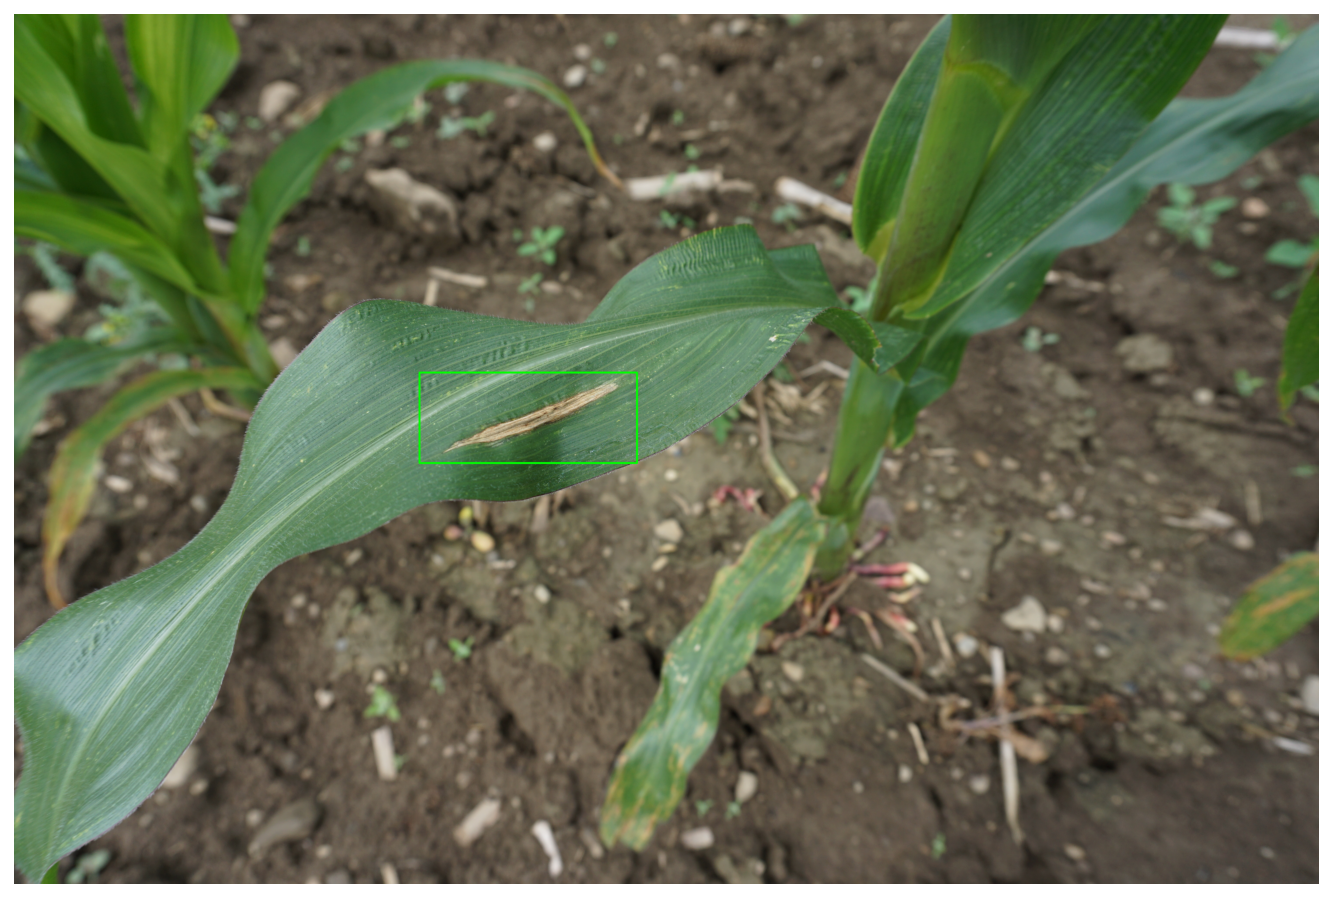

In [17]:
img_df = df[df.file_name == df.file_name.unique()[0]]
img = annotate_image(img_df)

plt.imshow(img)
plt.axis('off');

In [18]:
sample_images = [annotate_image(df[df.file_name == f]) for f in df.file_name.unique()[:10]]
sample_images = torch.as_tensor(sample_images)

In [19]:
sample_images.shape

torch.Size([10, 4000, 6000, 3])

In [20]:
sample_images = sample_images.permute(0, 3, 1, 2)
sample_images.shape

torch.Size([10, 3, 4000, 6000])

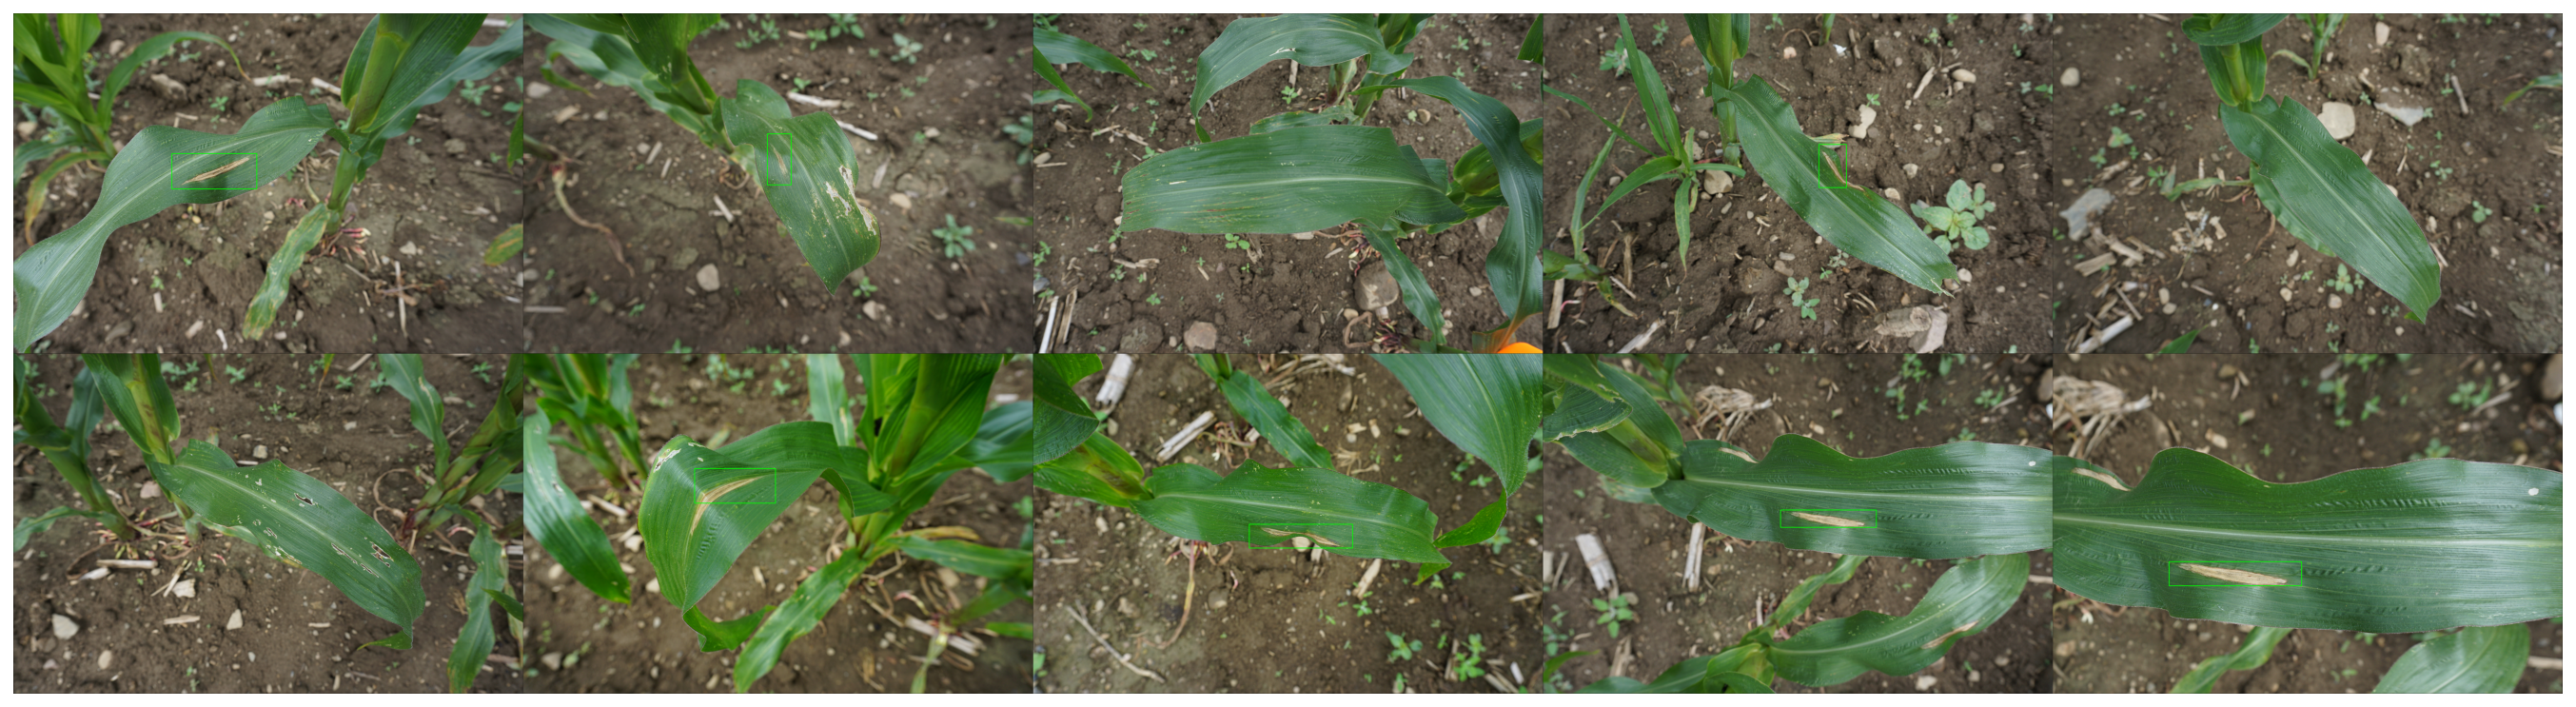

In [21]:
plt.figure(figsize=(24, 12))
grid_img = torchvision.utils.make_grid(sample_images, nrow=5)

plt.imshow(grid_img.permute(1, 2, 0))
plt.axis('off');

**Maize disease symptoms detection with Detectron2**

In [22]:
df.to_csv(f'{dataset_dir}/annotations.csv', header=True, index=None)

In [23]:
df = pd.read_csv(f'{dataset_dir}/annotations.csv')


IMAGES_PATH = f'{dataset_dir}'

unique_files = df.file_name.unique()

train_files = set(np.random.choice(unique_files, int(len(unique_files) * 0.80), replace=False))
train_df = df[df.file_name.isin(train_files)]
test_df = df[~df.file_name.isin(train_files)]

train_df.head()

file_name  height  width  x_min  y_min  x_max  y_max  \
0  DSC00025.JPG    4000   6000   1864   2064   2864   1648   
2  DSC00027.JPG    4000   6000      0      0      0      0   
3  DSC00028.JPG    4000   6000   3248   1540   3572   2048   
4  DSC00028.JPG    4000   6000   3444   1916   3852   2116   
5  DSC00029.JPG    4000   6000      0      0      0      0   

             class_name  
0  Northern Leaf Blight  
2  Northern Leaf Blight  
3  Northern Leaf Blight  
4  Northern Leaf Blight  
5  Northern Leaf Blight

In [24]:
classes = df.class_name.unique().tolist()
print(classes)

['Northern Leaf Blight']


In [25]:
def create_dataset_dicts(df, classes):
  dataset_dicts = []
  for image_id, img_name in enumerate(df.file_name.unique()):

    record = {}
    

    image_df = df[df.file_name == img_name]

    file_path = f'{IMAGES_PATH}/{img_name}'

    record["file_name"] = file_path
    record["image_id"] = image_id
    record["height"] = int(image_df.iloc[0].height)
    record["width"] = int(image_df.iloc[0].width)

    objs = []
    for _, row in image_df.iterrows():

      xmin = int(row.x_min)
      ymin = int(row.y_min)
      xmax = int(row.x_max)
      ymax = int(row.y_max)

      poly = [
          (xmin, ymin), (xmax, ymin), 
          (xmax, ymax), (xmin, ymax)
      ]
      poly = list(itertools.chain.from_iterable(poly))

      obj = {
        "bbox": [xmin, ymin, xmax, ymax],
        "bbox_mode": BoxMode.XYXY_ABS,
        "segmentation": [poly],
        "category_id": classes.index(row.class_name),
        "iscrowd": 0
      }
      objs.append(obj)

    record["annotations"] = objs
    dataset_dicts.append(record)
  return dataset_dicts

In [26]:
for d in ["train", "val"]:
  DatasetCatalog.register("diseases_" + d, lambda d=d: create_dataset_dicts(train_df if d == "train" else test_df, classes))
  MetadataCatalog.get("diseases_" + d).set(thing_classes=classes)

statement_metadata = MetadataCatalog.get("diseases_train")

In [27]:
class CocoTrainer(DefaultTrainer):
  
  @classmethod
  def build_evaluator(cls, cfg, dataset_name, output_folder=None):

    if output_folder is None:
        os.makedirs("./coco_eval", exist_ok=True)
        output_folder = "./coco_eval"

    return COCOEvaluator(dataset_name, cfg, False, output_folder)

In [28]:
cfg = get_cfg()

cfg.merge_from_file(
  model_zoo.get_config_file(
    "COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"
  )
)

cfg.MODEL.WEIGHTS = "https://dl.fbaipublicfiles.com/detectron2/COCO-Detection/faster_rcnn_R_50_FPN_3x/137849458/model_final_280758.pkl"

In [29]:
cfg.DATASETS.TRAIN = ("diseases_train",)
cfg.DATASETS.TEST = ("diseases_val",)
cfg.DATALOADER.NUM_WORKERS = 4
cfg.OUTPUT_DIR = './output'

In [30]:
cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.001
cfg.SOLVER.WARMUP_ITERS = 1000
cfg.SOLVER.MAX_ITER = 1500
cfg.SOLVER.STEPS = (1000, 1500)
cfg.SOLVER.GAMMA = 0.05

In [31]:
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 16
cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(classes)

cfg.TEST.EVAL_PERIOD = 500


In [ ]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

trainer = CocoTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[06/17 19:47:57 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Some model parameters or buffers are not found in the checkpoint:
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, we

[06/17 19:48:02 d2.engine.train_loop]: Starting training from iteration 0
[06/17 19:48:09 d2.data.build]: Distribution of instances among all 1 categories:
|   category    | #instances   |
|:-------------:|:-------------|
| Northern Le.. | 1577         |
|               |              |
[06/17 19:48:09 d2.data.common]: Serializing 354 elements to byte tensors and concatenating them all ...
[06/17 19:48:09 d2.data.common]: Serialized dataset takes 0.17 MiB
[06/17 19:48:09 d2.data.dataset_mapper]: Augmentations used in training: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[06/17 19:48:09 d2.evaluation.coco_evaluation]: 'diseases_val' is not registered by `register_coco_instances`. Therefore trying to convert it to COCO format ...
WARNING [06/17 19:48:09 d2.data.datasets.coco]: Using previously cached COCO format annotations at './coco_eval/diseases_val_coco_format.json'. You need to clear the cache file if your dataset has been modified.
[06/1

In [ ]:
%load_ext tensorboard

In [ ]:
#%tensorboard --logdir output
# %tensorboard --logdir="./output"
!pip install 'tensorboard<2.4'

import sagemaker
sagemaker_session = sagemaker.Session()

print("SageMaker ver: " + sagemaker.__version__)

aws_region = sagemaker_session.boto_region_name

!AWS_REGION={aws_region} tensorboard --logdir="./output"

     |████████████████████████████████| 6.8 MB 19.5 MB/s eta 0:00:01
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.5.0
    Uninstalling tensorboard-2.5.0:
      Successfully uninstalled tensorboard-2.5.0
SageMaker ver: 2.42.1
2021-06-17 19:50:20.461847: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.3.0 at http://localhost:6006/ (Press CTRL+C to quit)


In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.85
cfg.MODEL.ROI_HEADS.NMS_THRESH_TEST = 0.5
predictor = DefaultPredictor(cfg)
print(cfg.MODEL.WEIGHTS)

In [ ]:
cfg.dump()

In [ ]:
evaluator = COCOEvaluator("diseases_val", cfg, False, output_dir="./output")
val_loader = build_detection_test_loader(cfg, "diseases_val")
inference_on_dataset(trainer.model, val_loader, evaluator)

Find Diseases in the Images

In [ ]:
os.makedirs("annotated_results_faster_rcnn", exist_ok=True)

test_image_paths = test_df.file_name.unique()

In [ ]:
for clothing_image in test_image_paths:
  file_path = f'{IMAGES_PATH}/{clothing_image}'
  im = cv2.imread(file_path)
  outputs = predictor(im)
  v = Visualizer(
    im[:, :, ::-1],
    metadata=statement_metadata, 
    scale=1.2, 
    instance_mode=ColorMode.IMAGE
  )
  instances = outputs["instances"].to("cpu")
  instances.remove('pred_masks')
  #instances.
  v = v.draw_instance_predictions(instances)
  result = v.get_image()[:, :, ::-1]
  file_name = ntpath.basename(clothing_image)
  write_res = cv2.imwrite(f'annotated_results_faster_rcnn/{file_name}', result)

In [ ]:
annotated_images = [f'annotated_results_faster_rcnn/{f}' for f in test_df.file_name.unique()]

In [ ]:
img = cv2.cvtColor(cv2.imread(annotated_images[230]), cv2.COLOR_BGR2RGB)

plt.imshow(img)
plt.axis('off');

Deployment

In [ ]:
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.config import get_cfg
from detectron2.data import build_detection_test_loader
from detectron2.evaluation import COCOEvaluator, inference_on_dataset, print_csv_format
from detectron2.export import add_export_config, export_caffe2_model
from detectron2.modeling import build_model



# create a torch model
torch_model = build_model(cfg)
DetectionCheckpointer(torch_model).resume_or_load(cfg.MODEL.WEIGHTS)

# get a sample data
data_loader = build_detection_test_loader(cfg, cfg.DATASETS.TEST[0])
first_batch = next(iter(data_loader))

# convert and save caffe2 model
caffe2_model = export_caffe2_model(cfg, torch_model, first_batch)
caffe2_model.save_protobuf('./caffe2_model')
# draw the caffe2 graph
caffe2_model.save_graph(os.path.join('./caffe2_model', "model.svg"), inputs=first_batch)

# run evaluation with the converted model
if args.run_eval:
    dataset = cfg.DATASETS.TEST[0]
    data_loader = build_detection_test_loader(cfg, dataset)
    # NOTE: hard-coded evaluator. change to the evaluator for your dataset
    evaluator = COCOEvaluator(dataset, cfg, True, './caffe2_model')
    metrics = inference_on_dataset(caffe2_model, data_loader, evaluator)
    print_csv_format(metrics)